### Importing required libraries

In [26]:
import torch
from torch.utils.data import Dataset
import torchvision #provide access to datasets, models, transforms, utils, etc
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [27]:
# declaring constants for epoch and batch size
EPOCH = 20
BATCH_SIZE = 128

### Testing for creating custom dataset in required format

In [28]:
# creating MNIST dataset from inbuilt datasets
mnist_train_set = torchvision.datasets.MNIST(
            root='./try1',
            train=True,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor()
            ])
        )

In [29]:
# trying the sum of 60000 random integers with labels of train dataset of mnist
sum_labels = mnist_train_set.targets + torch.randint(0, 9, (1, 60000)).squeeze()
sum_labels

tensor([11,  2, 11,  ..., 13, 10, 12])

In [30]:
# accessing a sample from dataset 
sample = next(iter(mnist_train_set))
image, label = sample
image.dtype

torch.float32

label: 5


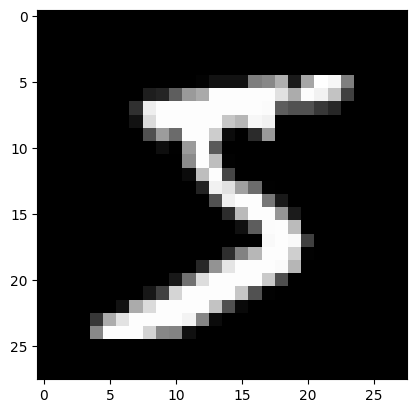

In [31]:
# visulaizing the sample from dataset
plt.imshow(image.squeeze(), cmap='gray')
print('label:', label)

In [32]:
len(mnist_train_set.data) # checking the length of dataset

60000

#### Creating random integers between 0 to 9 similar to size of dataset

In [33]:
rn = torch.randint(0, 9, (1, 60000)).squeeze() 
rn[1]

tensor(7)

#### Converting labels for addtion into their respective probability distribution

This is necessory for feeding it to Cross Entropy Loss function for calculating loss, as it expects the tensors containing the values ranging between 0 and 1. 
- first we convert the sum into their respective binary represenation
- dividing it by count of ones to find the respective probability distribution

In [34]:
def to_pd(num):
    binary = torch.zeros((5,), dtype=torch.float32) #creating tensor of size five containing only zeros for binary 
    i = 0
    # converting the number to binary
    while(num != 0):
        if num % 2 == 1:
            binary[i] = 1.0
        num = torch.div(num, 2, rounding_mode='trunc')
        i +=1
    ones = (binary == 1.0).sum(dim=0) # counting the number of ones to use it to divide the binary tensor
    #we will be having maximum one count = 4, as the maximum value we will have is 18
    if ones == 2: # if number of ones = two, prob = 0.5
        pd = binary / 2.0 
    if ones == 3: # if number of ones = two, prob = 0.33 
        pd = binary / 3.0
    if ones == 4: # if number of ones = two, prob = 0.25
        pd = binary / 4.0

    return pd

to_pd(13)

tensor([0.3333, 0.0000, 0.3333, 0.3333, 0.0000])

## Creating our required Custom Dataset Class

In [35]:
class MNISTWithNumbers(Dataset):

    def __init__(self):
        # creating dataset for MNIST images
        self.mnist_data = torchvision.datasets.MNIST(
            root='./data',
            train=True,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor()
            ])
        )
        # creating data for random integers between 0 and 9 with the size of MNIST data
        self.random_numbers = torch.randint(0, 9, (1, len(self.mnist_data.targets))).squeeze()
        # One Hot Encoding the random numbers to be used for NN
        self.numbers = torch.zeros((len(self.mnist_data.targets), 10))
        for i in range(len(self.mnist_data.targets)):
            self.numbers[i][self.random_numbers[i]] = 1

    # implementing __getitem__ method 
    def __getitem__(self, index):
        sample = self.mnist_data[index]
        image = sample[0]
        label = torch.tensor(sample[1])
        number = self.numbers[index]
        sum_ = label + self.random_numbers[index]
        sum_label = to_pd(sum_)
        # returing the image, label of image, one-hot encoded number, and probability distribution of sums
        return image, label, number, sum_label 

    def __len__(self):
        return len(self.mnist_data.data) # returning the size of data for iterating
    
    @property #  property for accessing the labels
    def train_labels(self): 
        sum_labels = self.mnist_data.targets + self.random_numbers
        return self.mnist_data.targets, sum_labels


In [36]:
mnist_with_numbers = MNISTWithNumbers() # creating dataset object 

In [37]:
targets, sum_labels = mnist_with_numbers.train_labels # checking the size of labels for both the predictions
targets.shape, sum_labels.shape

(torch.Size([60000]), torch.Size([60000]))

In [38]:
sample = next(iter(mnist_with_numbers)) # checking if we are able to access the data and labels
image, label, number, sum_label = sample
image.shape, label.shape, number.shape, sum_label.shape

(torch.Size([1, 28, 28]), torch.Size([]), torch.Size([10]), torch.Size([5]))

In [39]:
number, sum_label, label # checking if the data is created in the required manner

(tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 0., 1., 0.]),
 tensor(5))

In [40]:
# passing dataset to Data Loader to feed NN in batches
train_data_loader = torch.utils.data.DataLoader(
    mnist_with_numbers,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [41]:
batch = next(iter(train_data_loader))
images, labels, numbers, sum_labels = batch
images.shape, labels.shape, numbers.shape, sum_labels.shape

(torch.Size([128, 1, 28, 28]),
 torch.Size([128]),
 torch.Size([128, 10]),
 torch.Size([128, 5]))

In [42]:
class Network(nn.Module):
    def __init__(self,):
        super().__init__()
        # defining the required layers for building the NN architecture
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3) 
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.fc1 = nn.Linear(in_features=1600, out_features=120)
        self.fc2 = nn.Linear(in_features=130, out_features=60)
        self.out1 = nn.Linear(in_features=60, out_features=10)
        self.fc3 = nn.Linear(in_features=60, out_features=30)
        self.out2 = nn.Linear(in_features=30, out_features=5)

    def forward(self, t1, t2):
        # input layer
        x1 = t1
        x2 = t2

        # conv1 layer
        x1 = self.conv1(x1) # 28 | 26
        x1 = F.relu(x1)

        # conv2 layer
        x1 = self.conv2(x1) # 26 | 24
        x1 = F.relu(x1)
        x1 = F.max_pool2d(x1, kernel_size=2, stride=2) # 24 | 12
        
        # conv3 layer
        x1 = self.conv3(x1) # 12 | 10
        x1 = F.relu(x1)
        x1 = F.max_pool2d(x1, kernel_size=2, stride=2) # 10 | 5

        # flattening the tensor till dimension 1 and keeping the batches
        x1 = x1.flatten(1) # 64 * 5 * 5 = 1600

        # fc1 layer
        x1 = self.fc1(x1) # 1600 | 120
        x1 = F.relu(x1)

        # concatenating the random number tensor with output from first fully connected layer
        # combined the inputs here as this layer has only 120 neurons and adding 10 more will 
        # be significant in number than the previous layer as it has 1600 neurons, if the random 
        # number was combined in last layer the chances of ignoring it by NN would have been higher, 
        # but here in the current layer of 120 neurons adding it would give the needed attention 
        # by NN for addition with label of MNIST
        x = torch.cat((x1, x2), 1) # 120 + 10 

        # fc2 layer 
        x = self.fc2(x) # 130 | 60
        x = F.relu(x)

        #  out1 layer
        out1 = self.out1(x) # 60 | 10
        out1 = F.softmax(out1, dim=1)

        # branching out fully connected hidden layer from the last hidden layer (for first output)  
        # for addition of MNIST label and random number
        # fc3 layer
        out2 = self.fc3(x) # 60 | 30
        out2 = F.relu(out2)

        # out2 layer

        out2 = self.out2(out2) # 30 | 5
        out2 = F.softmax(out2, dim=1)

        return out1, out2


In [43]:
network = Network()

In [44]:
# checking whether NN is giving the required output
out1, out2 = network(image.unsqueeze(0), number.unsqueeze(0))
out1, out2

(tensor([[0.0875, 0.0937, 0.1133, 0.0961, 0.1123, 0.0908, 0.0917, 0.1098, 0.1124,
          0.0925]], grad_fn=<SoftmaxBackward0>),
 tensor([[0.1977, 0.2441, 0.1743, 0.2130, 0.1709]], grad_fn=<SoftmaxBackward0>))

In [45]:
# devising the strategy for evaluating the accuracy for addition
sum_labels[sum_labels > 0] = 1
sum_labels

out1, out2 = network(images, numbers)
n = sum_labels[0].eq(1.).sum().item()
_, indices = torch.topk(out2[0], n)
print(out2[0])
out2[0][indices] = 1.
out2[0][out2[0] < 1] = 0.
out2[0], sum_labels[0], torch.all(out2[0].eq(sum_labels[0]))

tensor([0.1990, 0.2419, 0.1729, 0.2139, 0.1723], grad_fn=<SelectBackward0>)


(tensor([1., 1., 0., 1., 0.], grad_fn=<SelectBackward0>),
 tensor([1., 1., 1., 0., 0.]),
 tensor(False))

#### Evaluation function for calculating accuracy 

In [46]:
def get_preds_correct(preds, labels): # for calculating the total correct prediction made for MNIST images
    return preds.argmax(dim=1).eq(labels).sum().item()

def get_preds_sum_correct(preds, labels, batch_size): # for calculating the total correct prediction for addition 
    count = 0
    labels[labels > 0] = 1. # converting the probabilites back into ones (binary represntation)
    for i in range(batch_size):
        n =  labels[i].eq(1.).sum().item() # n = number of ones in the binary
        if n > 0:
            _, index = torch.topk(preds[i], n) # taking the indices for top n values in prediction to match against the label
            preds[i][index] = 1.                # converting the top n values into 1 
    preds[preds<1] = 0.
    for i in range(batch_size):
        if torch.all(labels[i].eq(preds[i])):   # checking if the predictions are equal to labels 
            count += 1
    return count

In [47]:
get_preds_correct(out1, labels), get_preds_sum_correct(out2, sum_labels, 32)

(16, 9)

#### Testing if everything is working fine

In [48]:
import torch.optim as optim

mnist_with_numbers = MNISTWithNumbers()

train_loader = torch.utils.data.DataLoader(
    mnist_with_numbers,
    batch_size=BATCH_SIZE,
    shuffle=True
)

network = Network()
# optimizer for performing weight updates using Adam optimizer
optimizer = optim.Adam(network.parameters(), lr=0.001)

batch = next(iter(train_loader)) #get batch
images, labels, numbers, sum_labels = batch
pred_labels, pred_sums = network(images, numbers)
loss_image = F.cross_entropy(pred_labels, labels) # calculating loss for image
loss_sum = F.cross_entropy(pred_sums, sum_labels) # calculating loss for sum

loss_image.backward(retain_graph=True) #calculate gradients and save the graph for update by the loss for additon
loss_sum.backward() # calculate the gradients for the addition
optimizer.step() #update weights

print('loss1:', loss_image.item(), loss_sum.item())
pred_labels, pred_sums = network(images, numbers)
loss_image = F.cross_entropy(pred_labels, labels) 
loss_sum = F.cross_entropy(pred_sums, sum_labels)
print('loss2:',loss_image.item(), loss_sum.item())

loss1: 2.301152229309082 1.583652377128601
loss2: 2.300562858581543 1.5824871063232422


In [49]:
# checking if the GPU is available, and if yes, switching the process to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda


### Final Training 

In [50]:
network = Network()
optimizer = optim.Adam(network.parameters(), lr=0.001)
# shifting the parameters of the model to GPU
network.to(device)

for epoch in range(EPOCH):
    
    total_correct_MNIST = 0
    total_correct_sum = 0
    total_loss_MNIST = 0
    total_loss_sum = 0
    total_size = 0

    for batch in train_loader:
        images, labels, numbers, sum_labels = batch
        images, labels, numbers, sum_labels = images.to(device), labels.to(device), numbers.to(device), sum_labels.to(device)
        pred_images, pred_sums = network(images, numbers)
        loss_image = F.cross_entropy(pred_images, labels) # calculating loss for image
        loss_sum = F.cross_entropy(pred_sums, sum_labels) # calculating loss for addition

        optimizer.zero_grad() # set the grads to zero 
        loss_image.backward(retain_graph=True)
        loss_sum.backward()
        optimizer.step() # update weights

        # calculating total loss and accuracy for each epoch
        total_loss_MNIST += loss_image.item()
        total_correct_MNIST += get_preds_correct(pred_images, labels)
        total_loss_sum += loss_sum.item()
        total_correct_sum += get_preds_sum_correct(pred_sums, sum_labels, len(sum_labels))
        total_size += len(images)

    print(f'epoch: {epoch} \n \t MNIST: total loss: {total_loss_MNIST: .2f} acc: {total_correct_MNIST/total_size*100: .2f} \n \t Addition: total loss: {total_loss_sum: .2f} acc: {total_correct_sum/total_size*100: .2f}')

epoch: 0 
 	 MNIST: total loss:  841.63 acc:  66.52 
 	 Addition: total loss:  716.23 acc:  30.84
epoch: 1 
 	 MNIST: total loss:  742.74 acc:  87.79 
 	 Addition: total loss:  706.50 acc:  34.83
epoch: 2 
 	 MNIST: total loss:  714.16 acc:  94.09 
 	 Addition: total loss:  666.46 acc:  43.20
epoch: 3 
 	 MNIST: total loss:  693.29 acc:  98.48 
 	 Addition: total loss:  640.79 acc:  49.05
epoch: 4 
 	 MNIST: total loss:  691.48 acc:  98.83 
 	 Addition: total loss:  633.88 acc:  50.19
epoch: 5 
 	 MNIST: total loss:  690.57 acc:  98.96 
 	 Addition: total loss:  631.04 acc:  51.63
epoch: 6 
 	 MNIST: total loss:  689.55 acc:  99.17 
 	 Addition: total loss:  628.63 acc:  54.28
epoch: 7 
 	 MNIST: total loss:  688.89 acc:  99.29 
 	 Addition: total loss:  627.46 acc:  54.55
epoch: 8 
 	 MNIST: total loss:  688.53 acc:  99.37 
 	 Addition: total loss:  626.80 acc:  56.18
epoch: 9 
 	 MNIST: total loss:  688.17 acc:  99.43 
 	 Addition: total loss:  626.05 acc:  57.03
epoch: 10 
 	 MNIST:

#### Here we have achieved the accuracy of 99.78 % for MNIST images and 62.64 % accuracy for addition. 
- The accuracy for the MNIST images is calculted by equating the argmax of prediction and label of the image
- The accuracy for the addition is calculated by converting the prediction into kind of binary representation by taking the top n values, (where n is the number of ones present in labels) and equating it with the labels (binary represantation)